In [1]:
# import libraries
import os
import re
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tarfile
import matplotlib.image as image
import matplotlib.pyplot as plt

In [2]:
labels_encoder = {0: "Neutral", 1: "Happy", 2: "Sad", 3:"Surprise", 
                  4: "Fear", 5: "Disgust", 6: "Anger", 7: "Contempt"}

labels_encoder_binary = {0: "Non-Happy", 1: "Happy"}

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [4]:
def unzip_tar_file(source_path,destination_path):
    '''
    Read contents of .tar file into memory in Google Colab.
    '''
    zip_ref = tarfile.TarFile(source_path, 'r') 
    zip_ref.extractall(destination_path) 
    zip_ref.close()

def load_images_from_folder(folder,s,cnn = False):
    '''
    Read data images and their expression label (integer) in from folder.
    '''
    # get list of image filenames
    images = []
    labels = []
    imagefolder = folder+'/images'
    k = os.listdir(imagefolder)[:s]
    
    # read in all images and labels from folder
    for filename in k:
        # add image to list
        img = plt.imread(os.path.join(folder+'/images',filename))
        if img is not None:
            images.append(img)
        
        # get filename for label for this image ('exp' files give expression label as int)
        number = int(re.search(r'\d+',  filename)[0])
        label_filename = folder+'/annotations/'+str(number)+'_exp.npy'
        
        # get expression label and add to list, or label as "not face" and warn if label not found
        if os.path.isfile(label_filename):
            label = np.load(label_filename)
        else:
            label = 10
            print("Label for image %s not found"%filename)
        labels.append(int(label))
        
    images = np.array(images)
    print("Shape of images is ",np.shape(images))
    labels = np.array(labels)
    print("Shape of labels is ",np.shape(labels))
    
    if cnn:
      images = np.transpose(torch.tensor(images),[0,3,2,1])
      trainfeature= resnet(images/255)
      trainfeature = [x.clone().detach() for x in trainfeature]
      data = zip(trainfeature, labels)
      data = list(data)
    
    else:
      images = np.transpose(torch.tensor(images),[0,3,2,1])
      images = images/255
      images = [x.clone().detach() for x in images]
      data = zip(images, labels)
      data =  list(data)
    
    return data,images

In [5]:
train_path = '/content/gdrive/MyDrive/Colab Notebooks/Project/data/train_set.tar'
valid_path = '/content/gdrive/MyDrive/Colab Notebooks/Project/data/val_set.tar'
unzip_tar_file(train_path, '/content') 
unzip_tar_file(valid_path, '/content') 

traindata = load_images_from_folder('train_set',4000,cnn = False)
print("Shape of training data: ")
print(np.shape(traindata))

valdata = load_images_from_folder('val_set',400,cnn = False)
print("Shape of validation data: ")
print(np.shape(valdata))

Shape of images is  (4000, 224, 224, 3)
Shape of labels is  (4000,)
Shape of training data: 
(2, 4000)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Shape of images is  (400, 224, 224, 3)
Shape of labels is  (400,)
Shape of validation data: 
(2, 400)


In [6]:
def make_labelled_dataframe(path,lbl_extension,img_extension):
    '''
    Imports all images and labels from directory "path" to annotation (label)
    information and makes dataframe with all image filenames and their labels
    '''
    # add all filenames and labels to list
    labels_data = []
    for filename in tqdm(os.listdir(path)):
        if filename.endswith('_exp.npy'):
            img_filename = filename.replace(lbl_extension,img_extension)
            labels_data.append([img_filename, np.load(path+filename).item()])

    # convert list to DataFrame   
    labels_dataframe = pd.DataFrame(labels_data)
    labels_dataframe[1] = labels_dataframe[1].astype('int32')

    return labels_dataframe

def make_binary_dataframe(labels_dataframe,happy_ind_int,nonhappy_ind_list):
    '''
    Takes in dataframe with all filenames and labels and splits into equally sized
    happy and non-happy dataframes, then reassigns labels as 0=nonhappy, 1=happy and
    concatenates to make a binary dataframe.
    '''
    # get N, min number of training samples that have happy vs unhappy faces
    num_happy = np.count_nonzero(labels_dataframe[1] == happy_ind_int)
    num_nonhappy = np.count_nonzero(labels_dataframe[1] != happy_ind_int)
    min_num = min(num_happy,num_nonhappy)

    #print(num_happy)
    #print(num_nonhappy)

    # get N happy samples
    happy_mask = labels_dataframe[1]==happy_ind_int
    happy_df = labels_dataframe[happy_mask].sample(frac=1).iloc[:min_num]
    #print(happy_df.info())

    # get all unhappy samples, limit to N samples, and set new label to 0
    nonhappy_mask = labels_dataframe[1].isin(nonhappy_ind_list)
    nonhappy_df = labels_dataframe[nonhappy_mask].sample(frac=1).iloc[:min_num]
    nonhappy_df[1] = 0
    #print(nonhappy_df.info())

    # create a balanced dataframe
    balanced_dataframe = pd.concat([happy_df,nonhappy_df])
    print(balanced_dataframe.info())
    #print(balanced_dataframe)

    return balanced_dataframe

100%|██████████| 1150604/1150604 [05:12<00:00, 3680.15it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287651 entries, 0 to 287650
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       287651 non-null  object
 1   1       287651 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 3.3+ MB
None


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


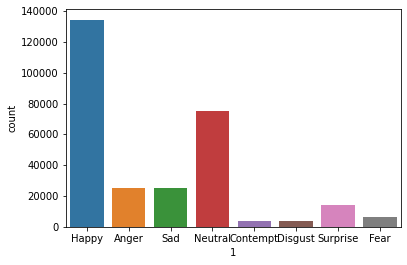

In [7]:
# train set data visualization
train_dir = 'train_set/annotations/'
labels_df = make_labelled_dataframe(train_dir,'_exp.npy','.jpg')
print(labels_df.info())

# plot data architecture before binarization
sns.countplot(labels_df[1].map(labels_encoder))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268830 entries, 177273 to 87215
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       268830 non-null  object
 1   1       268830 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.2+ MB
None


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


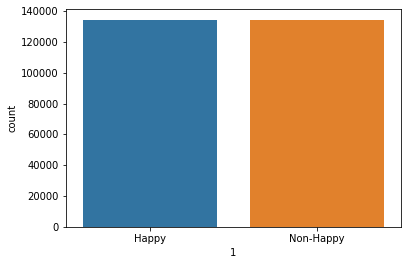

In [8]:
index_happy = 1
indices_nonhappy = [0,2,3,4,5,6,7]
balanced_df = make_binary_dataframe(labels_df,index_happy,indices_nonhappy)

# plot data architecture after binarization
sns.countplot(balanced_df[1].map(labels_encoder_binary))

In [9]:
balanced_df.to_csv(train_dir+'labels.csv', index=False)
print("labels.csv created at "+train_dir)

labels.csv created at train_set/annotations/


100%|██████████| 15996/15996 [00:04<00:00, 3939.62it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       3999 non-null   object
 1   1       3999 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 47.0+ KB
None


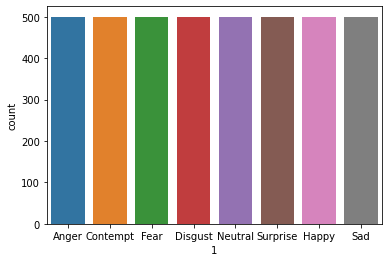

In [10]:
# valid set data visualization
#labels_dir = './data/val_set/annotations/'
valid_dir = 'val_set/annotations/'
labels_df = make_labelled_dataframe(valid_dir,'_exp.npy','.jpg')
print(labels_df.info())

# plot data architecture before binarization
sns.countplot(labels_df[1].map(labels_encoder))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 2760 to 1949
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1000 non-null   object
 1   1       1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB
None


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


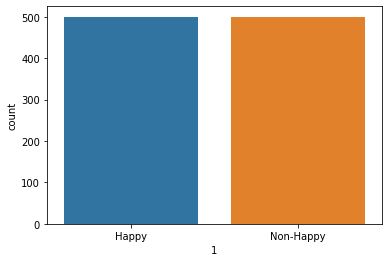

In [11]:
balanced_df = make_binary_dataframe(labels_df,index_happy,indices_nonhappy)

# plot data architecture after binarization
sns.countplot(balanced_df[1].map(labels_encoder_binary))

In [12]:
balanced_df.to_csv(valid_dir+'labels.csv', index=False)
print("labels.csv created at "+valid_dir)

labels.csv created at val_set/annotations/


In [13]:
!cp "train_set/annotations/labels.csv" "/content/gdrive/MyDrive/Colab Notebooks/Project/data/train_labels.csv"
!cp "val_set/annotations/labels.csv" "/content/gdrive/MyDrive/Colab Notebooks/Project/data/val_labels.csv"

In [ ]:
%%shell
jupyter nbconvert --to html Data_Visualization_Preprocessing_Binary.ipynb